[View in Colaboratory](https://colab.research.google.com/github/abhigoogol/Cifar10-DogsBreedIdentification/blob/master/CIFAR10_and_Dog_Breed_Identification.ipynb)

# Pre-installation

In [0]:
!pip install fastai
!pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
!pip install kaggle

#upload Kaggle Credentials
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle

!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v /content 
!kaggle config view

# Dogs Breeds Identification

In [25]:
!kaggle competitions download -c dog-breed-identification

- path is now set to: /content
Configuration values from /root/.kaggle
- username: abhisheksambyal
- path: /content
- proxy: None
- competition: None


In [4]:
!ls competitions/dog-breed-identification/
!unzip -qd competitions/dog-breed-identification/ competitions/dog-breed-identification/labels.csv.zip
!unzip -qd competitions/dog-breed-identification/ competitions/dog-breed-identification/sample_submission.csv.zip
!unzip -qd competitions/dog-breed-identification/ competitions/dog-breed-identification/test.zip
!unzip -qd competitions/dog-breed-identification/ competitions/dog-breed-identification/train.zip
!ls competitions/dog-breed-identification/

labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip
labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [5]:
!ls competitions/dog-breed-identification/

labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [6]:
!ls competitions/dog-breed-identification/train | head
# ls -a competitions/dog-breed-identification/test | head

000bec180eb18c7604dcecc8fe0dba07.jpg
001513dfcb2ffafc82cccf4d8bbaba97.jpg
001cdf01b096e06d78e9e5112d419397.jpg
00214f311d5d2247d5dfe4fe24b2303d.jpg
0021f9ceb3235effd7fcde7f7538ed62.jpg
002211c81b498ef88e1b40b9abf84e1d.jpg
00290d3e1fdd27226ba27a8ce248ce85.jpg
002a283a315af96eaea0e28e7163b21b.jpg
003df8b8a8b05244b1d920bb6cf451f9.jpg
0042188c895a2f14ef64a918ed9c7b64.jpg
ls: write error: Broken pipe


In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from fastai.torch_imports import *

In [0]:
PATH = 'competitions/dog-breed-identification/'

In [9]:
label_csv = f'{PATH}labels.csv'
print(label_csv)

competitions/dog-breed-identification/labels.csv


In [10]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(10222, 2044)

In [11]:
df = pd.read_csv(label_csv)
# df.head()

# df['breed'].value_counts()
#OR
df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


## Playing with Data

In [14]:
print(data.trn_ds.fnames)
print(data.trn_ds.fnames[0])
%matplotlib inline

['train/001513dfcb2ffafc82cccf4d8bbaba97.jpg' 'train/001cdf01b096e06d78e9e5112d419397.jpg'
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg' ... 'train/ffd3f636f7f379c51ba3648a9ff8254f.jpg'
 'train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg' 'train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg']
train/001513dfcb2ffafc82cccf4d8bbaba97.jpg


In [23]:
print(data.test_ds.fnames)
print(data.test_ds.fnames[0])
%matplotlib inline

['test/eab189c5274b79b36dd566fea4e9847e.jpg', 'test/696a0c7a76c7695f495f61272c873f02.jpg', 'test/e85291fc6ba44e39defc7769fa020646.jpg', 'test/e0a6b866af64299ecf76f7cb11c80674.jpg', 'test/c7802bfc81504a618254657300847c4d.jpg', 'test/ab558eaa2deb5a3307caf26e8e5eb779.jpg', 'test/3aa91929bc1ef5552e1e3259b2e7ea50.jpg', 'test/dd7bf84df93991b7c15ec739c82acc04.jpg', 'test/9ee85a81c98f14d7eb02c2cc0c17bb7d.jpg', 'test/2f90d005ca7d718be9377b94091849ba.jpg', 'test/7fd909c916ebab71b2f467ae43c90c8d.jpg', 'test/9a9449fca1ebb1b8262ccb8eb682996c.jpg', 'test/be0edd11dbafec5aec43877b2529ccdc.jpg', 'test/3690b4967b8548d375681d363e044135.jpg', 'test/35dc670bcda4be1818f5a944b4945162.jpg', 'test/8d88b714ded29910d3f20474f22519b1.jpg', 'test/812c0a953a2c7f83ef54e54aa46fd510.jpg', 'test/7fda3605993035df84afe29168a097c0.jpg', 'test/30da81132411638a1bdff15868e03ae3.jpg', 'test/758f9a07201494c594e3bd73063c9bdc.jpg', 'test/9f849a1f535ee8b31401f717ac41140f.jpg', 'test/c52405e4e5afb93a6ca775008480a41e.jpg', 'test/1c3

In [16]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

    100% |████████████████████████████████| 5.6MB 4.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
  Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 2.8MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.


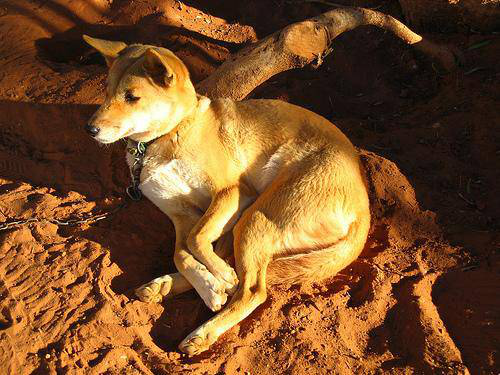

In [17]:
fn = PATH+data.trn_ds.fnames[0]; fn;
img = PIL.Image.open(fn); img

In [18]:
!head competitions/dog-breed-identification/sample_submission.csv

id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,english_setter,english_springer,entlebucher,eskimo_dog,flat-coated_retriever,french_bulldog,german_shepherd,german_short-haired_pointer,giant_schnauzer,golden_retriever,gordon_setter,great_dane,great_pyrenees,greater_swiss_mountain_dog,groenendael,ibizan_hound,irish_setter,irish_terrier,irish_water_spaniel,irish_wolfhound,italian_greyhound,japanese_spaniel,keeshond,kelpie,kerry_blue_terrier,komondor,kuvasz,labrador_retriever,lakeland_terrier,leonberg,lhasa,mala

In [15]:
data.classes[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [16]:
data.test_ds.fnames[:5]

['test/1db8160c22fc17c03f325c9149e83bcb.jpg',
 'test/df69bb4b3dbdc81541e2bd70a5f35cb1.jpg',
 'test/01641548f4a2988ee7a2ec783d177a98.jpg',
 'test/1475328e0e3f2ef000606db1df2dfb3e.jpg',
 'test/75c3350964fb0d32484b77bd51d50a11.jpg']

## Training

In [0]:
sz = 224
arch = resnet50
bs = 58

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [33]:
learn.fit(1e-2, 10)

epoch      trn_loss   val_loss   accuracy   
    0      1.382648   0.618394   0.855675  
    1      0.744901   0.492317   0.856654  
    2      0.555681   0.449734   0.863014  
 79%|███████▉  | 112/141 [00:03<00:00, 35.80it/s, loss=0.477]

    3      0.465827   0.434174   0.861057  
    4      0.404168   0.425699   0.870352  
    5      0.356935   0.423824   0.862035  
    6      0.349363   0.415265   0.868395  
 57%|█████▋    | 81/141 [00:02<00:01, 38.49it/s, loss=0.306]

    7      0.304865   0.416471   0.865949  
    8      0.264801   0.424048   0.866438  
    9      0.242163   0.421138   0.869863  


[array([0.42114]), 0.8698630171979244]

In [38]:
lrf = learn.lr_find()
print(lrf)

 84%|████████▎ | 118/141 [01:24<00:16,  1.40it/s, loss=1.01] None


In [0]:
learn.sched.plot_lr()

In [0]:
learn.precompute=False

In [41]:
learn.fit(1e-2, 4, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.317101   0.423951   0.870841  
    1      0.298098   0.418089   0.873288  
 74%|███████▍  | 104/141 [01:15<00:26,  1.38it/s, loss=0.298]

    2      0.297089   0.426645   0.872309  
    3      0.269274   0.422904   0.87182   
    4      0.279669   0.427717   0.870841  
 43%|████▎     | 61/141 [00:43<00:57,  1.39it/s, loss=0.28]

    5      0.278693   0.418601   0.870352  
    6      0.28302    0.42407    0.874266  
    7      0.266462   0.422251   0.872798  


[array([0.42225]), 0.8727984381748506]

In [0]:
learn.save('resnet50_224_58_1')
# learn.load('resnet50_224_58_1')
# del learn

# learn.save('resnext_299_32_1')
# learn.load('resnext_299_32_1')
# del learn

In [0]:
learn.unfreeze()
lr = np.array([1e-5, 1e-4, 1e-2])

In [45]:
# learn.fit(lr, 1, cycle_len=2)
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.393686   0.469867   0.8591    
    1      0.373196   0.473342   0.861546  
 74%|███████▍  | 104/141 [02:41<00:57,  1.56s/it, loss=0.346]

    2      0.325675   0.459849   0.864481  


[array([0.45985]), 0.8644814125012512]

## Prediction and Submission

In [0]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [48]:
print(log_preds.shape)
print(probs.shape)

(5, 10357, 120)
(10357, 120)


In [49]:
print(log_preds[4].shape)
print(probs[0].shape)
y.shape
# metrics.log_loss(y, np.exp(log_preds[0])), accuracy(log_preds[0],y)

(10357, 120)
(120,)


(10357, 1)

In [0]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [52]:
df.insert(0, 'id', [x[5:-4] for x in data.test_ds.fnames])
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1db8160c22fc17c03f325c9149e83bcb,2.709162e-09,1.255200e-07,1.483115e-05,1.621165e-07,2.272060e-07,1.393274e-06,3.068655e-07,6.997662e-06,2.102595e-07,...,6.792127e-08,2.584122e-07,1.439322e-07,2.093129e-07,1.132864e-08,8.091107e-08,1.124147e-07,5.839237e-07,1.235311e-07,9.364824e-09
1,df69bb4b3dbdc81541e2bd70a5f35cb1,4.535818e-07,1.146515e-07,4.914520e-07,1.912670e-07,7.365703e-06,1.693493e-01,3.009845e-07,3.603940e-05,2.458305e-06,...,3.229193e-07,1.439518e-06,2.545661e-07,1.029795e-05,1.271566e-07,2.698508e-06,6.755387e-07,2.969158e-06,7.705876e-07,8.670723e-08
2,01641548f4a2988ee7a2ec783d177a98,7.068264e-08,1.347548e-10,1.634074e-08,1.032498e-09,1.938713e-08,2.064610e-09,1.156590e-07,2.502843e-07,2.430335e-09,...,1.223604e-06,3.602689e-04,1.057317e-08,7.017433e-10,5.427978e-09,1.537882e-09,2.071827e-07,4.258277e-09,2.977257e-09,3.749694e-08
3,1475328e0e3f2ef000606db1df2dfb3e,3.454863e-05,5.455097e-05,4.906702e-04,6.415244e-02,5.292915e-04,1.950545e-04,5.841668e-03,3.787102e-05,3.742217e-04,...,6.592974e-06,9.685897e-04,4.474749e-04,7.674181e-04,1.723942e-03,1.694230e-03,1.911309e-05,9.894846e-05,4.466184e-04,1.461369e-03
4,75c3350964fb0d32484b77bd51d50a11,6.987867e-06,2.657042e-05,1.029234e-06,1.061323e-05,7.757877e-03,7.159046e-06,2.228980e-04,1.026636e-02,2.468857e-05,...,7.015002e-06,4.304138e-01,1.144465e-04,4.206277e-01,4.825026e-06,1.408125e-05,3.401798e-05,3.733105e-04,4.290254e-03,7.717854e-06


In [0]:
df.to_csv('./submission.csv', index=False)

In [54]:
!head submission.csv

id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,english_setter,english_springer,entlebucher,eskimo_dog,flat-coated_retriever,french_bulldog,german_shepherd,german_short-haired_pointer,giant_schnauzer,golden_retriever,gordon_setter,great_dane,great_pyrenees,greater_swiss_mountain_dog,groenendael,ibizan_hound,irish_setter,irish_terrier,irish_water_spaniel,irish_wolfhound,italian_greyhound,japanese_spaniel,keeshond,kelpie,kerry_blue_terrier,komondor,kuvasz,labrador_retriever,lakeland_terrier,leonberg,lhasa,mala

In [55]:
!kaggle competitions submit -c dog-breed-identification -f submission.csv -m "Submission 2 to Dog Breed Identification"

Successfully submitted to Dog Breed Identification

# CIFAR 10

In [10]:
!kaggle competitions download -c cifar-10

  0% 0.00/3.04M [00:00<?, ?B/s]
100% 3.04M/3.04M [00:00<00:00, 122MB/s]
 98% 595M/610M [00:07<00:00, 79.5MB/s]
100% 610M/610M [00:07<00:00, 88.4MB/s]
 90% 94.0M/105M [00:01<00:00, 50.7MB/s]
100% 105M/105M [00:01<00:00, 69.3MB/s] 
  0% 0.00/575k [00:00<?, ?B/s]
100% 575k/575k [00:00<00:00, 202MB/s]


In [0]:
!p7zip -d competitions/cifar-10/train.7z

In [50]:
!p7zip -d competitions/cifar-10/test.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 639374249 bytes (610 MiB)

Extracting archive: competitions/cifar-10/test.7z
--
Path = competitions/cifar-10/test.7z
Type = 7z
Physical Size = 639374249
Headers Size = 1721070
Method = LZMA:26
Solid = +
Blocks = 1

  0%      0% - test/1.png                   0% 873 - test/100783.png                            0% 1309 - test/101175.png                             0% 1639 - test/101472.png                             0% 1841 - test/101654.png                           

In [30]:
!ls competitions/cifar-10/test.7z

sampleSubmission.csv  test.7z  train.7z  trainLabels.csv


In [48]:
!ls

competitions  models  sample_data  tmp	train  trainLabels.csv


## Code

In [0]:
from fastai.imports import*
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH = '.'
sz = 224
arch = resnet50
bs = 16

label_csv = f'competitions/cifar-10/trainLabels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [35]:
len(val_idxs)

10000

In [0]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, bs=bs, tfms=tfms,
                                   val_idxs=val_idxs, suffix='.png')

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 625/625 [01:31<00:00,  7.46it/s]


In [42]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy   
    0      1.05787    0.803226   0.7179    
    1      0.912564   0.757625   0.7379    
    2      0.879122   0.711455   0.751     
    3      0.865413   0.705146   0.7529    
    4      0.802086   0.688553   0.7606    



[array([0.68855]), 0.7606]

In [43]:
learn.precompute = False
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.866167   0.681336   0.7601    
    1      0.904361   0.673465   0.7656    



[array([0.67347]), 0.7656]